In [2]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('model.csv')
#df = df[df['likes']<20000]


df_numerical=df.select_dtypes(include=[np.number])
df_categorical=df.select_dtypes(include=['object'])
dummies = pd.get_dummies(df_categorical) 


# #TRYING THE LOGARITHMIC EXPRESSION ON THE DATA: 
df_numerical[' title_subjectivity']=df_numerical[' title_subjectivity'].apply(lambda x: math.log(x+1))
df_numerical[' rate_positive_words']=df_numerical[' rate_positive_words'].apply(lambda x: math.log(x+1))
df_numerical['topic_quality']=df_numerical['topic_quality'].apply(lambda x: math.log(x+1))
df_numerical[' self_reference_avg_sharess']=df_numerical[' self_reference_avg_sharess'].apply(lambda x: math.log(x+1))
df_numerical[' num_keywords']=df_numerical[' num_keywords'].apply(lambda x: math.log(x+1))
df_numerical[' average_token_length']=df_numerical[' average_token_length'].apply(lambda x: math.log(x+1))
df_numerical[' n_non_stop_words']=df_numerical[' n_non_stop_words'].apply(lambda x: math.log(x+1))






##########################################################################################


#ADDING AND REMOVING COLUMNS TO GET THE BEST VALUES:
# df_numerical= df[['age_days',  ' n_unique_tokens', ' average_token_length', 'topic_quality','likes' ]]

# df_categorical= df[['day','product_category', ' n_tokens_title',' num_keywords',' min_positive_polarity', ' max_positive_polarity',
#                    ' min_negative_polarity',' max_negative_polarity',' abs_title_subjectivity',' abs_title_sentiment_polarity']]

# dummies = pd.get_dummies(df_categorical) 

# df_numerical= df[['age_days',  ' n_tokens_review', ' n_unique_tokens',
#        ' n_non_stop_words', ' n_non_stop_unique_tokens', ' num_hrefs',
#        ' num_self_hrefs', ' num_imgs', ' num_videos', ' average_token_length',
#        'topic_quality', 'topic_shipping', 'topic_packaging',
#        'topic_description', 'topic_others', ' global_subjectivity',
#        ' global_sentiment_polarity', ' global_rate_positive_words',
#        ' global_rate_negative_words', ' rate_positive_words',
#        ' rate_negative_words', ' avg_positive_polarity',
#        ' avg_negative_polarity',  ' title_subjectivity',
#        ' title_sentiment_polarity', 
#         'likes']]

# df_numerical=df_numerical[['age_days',   ' n_unique_tokens', ' num_videos', ' average_token_length',
#        ' num_keywords', ' self_reference_min_shares',
#        ' self_reference_avg_sharess',
#        'topic_quality', 'topic_shipping', 
#     'likes']]

             
##########################################################################################
# # # Standarize
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler().fit(df_numerical)
# scaled_df = pd.DataFrame(scaler.transform(df_numerical))
# scaled_df.columns = df_numerical.columns
# scaled_df.head()
# #Save the scaler
# import pickle
# pickle.dump(scaler, open('scaler.pkl', 'wb'))
# scaled_df.boxplot()

columns=df_numerical.columns
from sklearn.preprocessing import MinMaxScaler
mm_scaler =  MinMaxScaler(copy=False,feature_range=(0, 500))
mm_scaler.fit(df_numerical)
minmax_data=mm_scaler.transform(df_numerical)
mmscaled_df=pd.DataFrame(minmax_data)
mmscaled_df.columns = columns
df_num=mmscaled_df
##########################################################################################

import math
X=pd.concat([dummies,mmscaled_df], axis = 1)
X=X.dropna(axis=0)
y=df_numerical['likes'].apply(lambda x: math.log(x+1))
z=X
X=X.drop(["likes"], axis=1)

##########################################################################################

from sklearn.model_selection import train_test_split
#SPLIT DATA INTO TRAIN AND TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size =0.30, #by default is 75%-25%
                                                    random_state= 123) #fix random seed for replicability

print(X_train.shape, X_test.shape)



##########################################################################################
from sklearn.model_selection import GridSearchCV
import math
def gs_regression(model, par) :
    gs = GridSearchCV(model, par,cv=3,scoring ='neg_mean_absolute_error') 
    gs = gs.fit(X_train,y_train)

    #summarize the results of your GRIDSEARCH
    print('***GRIDSEARCH RESULTS***')
    print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
    means = gs.cv_results_['mean_test_score']
    stds = gs.cv_results_['std_test_score']
    params = gs.cv_results_['params']
    #for mean, stdev, param in zip(means, stds, params):
    #    print("%f (%f) with: %r" % (mean, stdev, param))
    
    y_pred_train=gs.predict(X_train)
    y_pred_test=gs.predict(X_test) 
    
    y_train_exp=y_train.apply(lambda x: math.exp(x)-1)
    y_test_exp=y_test.apply(lambda x: math.exp(x)-1)
    y_pred_train_exp=np.exp(y_pred_train)-1
    y_pred_test_exp=np.exp(y_pred_test)-1
    
            
    from sklearn import metrics
    print()
    print("MAE  train %.3f (%f)  test %.3f (%f)" % (metrics.mean_absolute_error(y_train, y_pred_train), metrics.mean_absolute_error(y_train_exp, y_pred_train_exp) ,metrics.mean_absolute_error(y_test, y_pred_test),  metrics.mean_absolute_error(y_test_exp, y_pred_test_exp)  ) )
    print("MSE  train %.3f              test %.3f" % (metrics.mean_squared_error(y_train, y_pred_train), metrics.mean_squared_error(y_test, y_pred_test)) ) 
    print("RMSE train %.3f              test %.3f" % (np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))) ) 
    print("r2   train %.3f              test %.3f" % (metrics.r2_score(y_train, y_pred_train), metrics.r2_score(y_test, y_pred_test)) )


<ipython-input-2-39867dc05c65>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numerical[' title_subjectivity']=df_numerical[' title_subjectivity'].apply(lambda x: math.log(x+1))
<ipython-input-2-39867dc05c65>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numerical[' rate_positive_words']=df_numerical[' rate_positive_words'].apply(lambda x: math.log(x+1))
<ipython-input-2-39867dc05c65>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

(19600, 50) (8400, 50)


In [ ]:
##########################################################################################

In [ ]:
##########################################################################################

In [16]:
##########################################################################################

# Chosen Model

In [3]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression() 
parameters = {}

gs_regression(regressor, parameters)

***GRIDSEARCH RESULTS***
Best score: -0.652955 using {}

MAE  train 0.651 (2443.891212)  test 0.654 (2400.811874)
MSE  train 0.763              test 0.778
RMSE train 0.873              test 0.882
r2   train 0.113              test 0.095


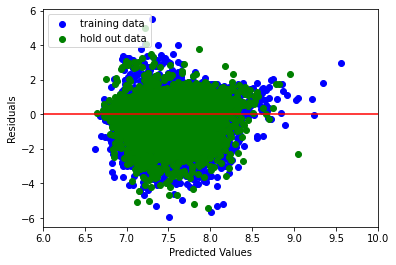

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
regressor = regressor.fit(X_train,y_train)

plt.scatter(regressor.predict(X_train),regressor.predict(X_train)-y_train, c="b", label="training data")
plt.scatter(regressor.predict(X_test),regressor.predict(X_test)-y_test, c="g", label="hold out data")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=-10, xmax=50, color="r")
plt.xlim([6,10])
plt.show()

In [5]:
# USING THE MEAN WHICH WOULD BE BETTER THAN USING ANY MODEL!
l=[]
for i in range(1,28001):
  l.append(3408.232750)  
type(l)
list(z['likes'])
from sklearn import metrics
metrics.mean_absolute_error(list(z['likes']), l)

3406.2149313540936

# Errors

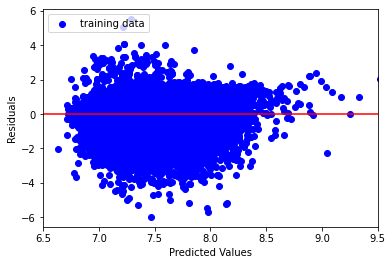

In [6]:
#retrain in the entire dataset

LR = LinearRegression()
LR.fit(X,y)
y_pred=LR.predict(X)
error=y_pred-y
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(y_pred,error, c="b", label="training data")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=0, xmax=10, color="r")
plt.xlim([6.5,9.5])
plt.show()

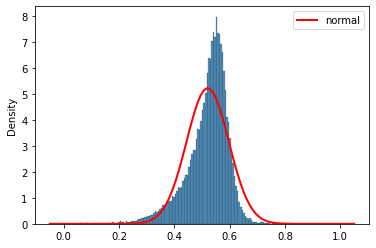

In [7]:
nb_error = np.array(error).flatten()

error = np.array(error).reshape(-1,1)
scaled_error= MinMaxScaler(copy=False).fit(error).transform(error).flatten()

import numpy as np
import scipy 
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
from matplotlib import pyplot as plt
import seaborn as sns


# We test a exponential distribution
dist = getattr(scipy.stats, 'norm')
param = dist.fit(scaled_error)

err_mean=param[-2]
err_std=param[-1]

# We generate a sample of size  len(mr_scaled) of data distributed according to distribution dist
# The function rvs generates a sample with distribution dist with mean loc and std scale
test_dist = dist.rvs(*param[0:-2],loc=param[-2], scale=param[-1],size = len(scaled_error))


# plot the distribution and compare with a normal

ax = sns.histplot(scaled_error, stat='density')

# calculate the pdf
x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
x_pdf = np.linspace(x0, x1, 100)
y_pdf = scipy.stats.norm.pdf(x_pdf, loc=err_mean, scale=err_std)

ax.plot(x_pdf, y_pdf, 'r', lw=2, label='normal')                                                   
ax.legend() 

#plt.hist(nb_error_train,alpha=.3, density=True,bins='auto')
#plt.hist(test_dist,alpha=.3, density=True,bins='auto')
#plt.show()

In [8]:
import pickle
pickle.dump(LR, open('LinearRegression.pkl', 'wb'))